# Imports

In [1]:
# help here: 
#  - https://www.youtube.com/watch?v=nNvPvvuPnGs 
#  - https://github.com/rsreetech/LDATopicModelling/blob/main/LDADemo.ipynb

import os
import time
import math
import warnings
from IPython.display import clear_output, HTML

import numpy as np
import pandas as pd
from pandarallel import pandarallel

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from wordcloud import WordCloud
import pprint

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter

import nltk
from nltk.corpus import stopwords

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim

# Configuration

In [2]:
PREVIEW_REVIEW_SIZE = 1000
CHUNK_SIZE = 10000
EXTRACT_PARQUET = True
PREPROCESS_IMAGES = True
EXTRACT_CNN_FEATURES = True

# SAMPLINg
SAMPLING_REVIEW_SIZE = 1000
SAMPLING_PHOTOS_SIZE = 100

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
ORIGINAL_PHOTOS_DIR = 'data/original/yelp_photos/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
WORK_PHOTOS_DIR = 'data/work/yelp_photos/'

PREFIX_YELP = 'yelp_academic_dataset_'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=matplotlib.MatplotlibDeprecationWarning)

sns.set()
pandarallel.initialize(progress_bar=True, verbose=False)

# Trick for jupyter lab with pyLdaVis
css_str = """<style> 
    .jp-Button path { fill: var(--jp-inverse-layout-color3);}
    .lm-TabBar-tabIcon path { fill: var(--jp-inverse-layout-color3);}
    .jp-icon-warn0 path {fill: var(--jp-inverse-layout-color3);}
    .bp3-button-text path {    fill: var(--jp-inverse-layout-color3);}
    .jp-icon-brand0 path { fill: var(--jp-inverse-layout-color3);}
    text.terms { fill: var(--jp-inverse-layout-color3);}
</style>"""  
display(HTML(css_str))

# Extractions des sujets des reviews

In [3]:
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Name', 'Size']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_REVIEW_SIZE)
    display(df.sample(5))
    display(df.dtypes)

    return df   

## Prévisualiastions des datasets

In [4]:
files = list_files(ORIGINAL_DATASET_DIR)
print('')
print(tabulate([[k,v] for k,v in files.items()]))

Name                                 Size
-----------------------------------  ------
yelp_academic_dataset_business.json  0.11Gb
yelp_academic_dataset_checkin.json   0.27Gb
yelp_academic_dataset_review.json    4.98Gb
yelp_academic_dataset_tip.json       0.17Gb
yelp_academic_dataset_user.json      3.13Gb

--------  --------------------------------------------------------------
business  data/original/yelp_dataset/yelp_academic_dataset_business.json
checkin   data/original/yelp_dataset/yelp_academic_dataset_checkin.json
review    data/original/yelp_dataset/yelp_academic_dataset_review.json
tip       data/original/yelp_dataset/yelp_academic_dataset_tip.json
user      data/original/yelp_dataset/yelp_academic_dataset_user.json
--------  --------------------------------------------------------------


In [5]:
preview_dfs = {}
for name in files:
    print(f'PREVIEW {name}\n=====================\n')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

PREVIEW business



business_id                       name  \
624  cm0bhBDPM3bjBefmEXa3BQ  Nudy's Cafe - Chadds Ford   
344  mHDBZmEH0Er3184YS83_LQ     Splash Car Wash & Lube   
727  18eWJFJbXyR9j_5xfcRLYA              Siam Elephant   
655  jKb0H78PubnEMa5JoXdnvw           Harpeth Cleaners   
5    CF33F8-E6oudUQ46HnavjQ             Sonic Drive-In   

                    address          city state postal_code   latitude  \
624  240 Painters' Crossing   Chadds Ford    PA       19317  39.880860   
344  802 W Bloomingdale Ave       Brandon    FL       33511  27.893920   
727          509 Linden Ave   Carpinteria    CA       93013  34.396510   
655        8127 Highway 100     Nashville    TN       37221  36.044073   
5             615 S Main St  Ashland City    TN       37015  36.269593   

      longitude  stars  review_count  is_open  \
624  -75.548277    3.5            63        1   
344  -82.294372    2.5            50        1   
727 -119.521681    4.5           460        1   
655  -86.955886    2.0             7        1   
5    -87.058943    2.0             6        1   

                                            attributes  \
624  {'RestaurantsReservations': 'False', 'Caters':...   
344  {'BusinessAcceptsCreditCards': 'True', 'WiFi':...   
727  {'RestaurantsGoodForGroups': 'True', 'Alcohol'...   
655  {'BusinessParking': '{'garage': False, 'street...   
5    {'BusinessParking': 'None', 'BusinessAcceptsCr...   

                                            categories  \
624  Breakfast & Brunch, Restaurants, American (Tra...   
344  Tires, Automotive, Auto Repair, Oil Change Sta...   
727                                  Restaurants, Thai   
655  Dry Cleaning, Local Services, Laundry Services...   
5    Burgers, Fast Food, Sandwiches, Food, Ice Crea...   

                                                 hours  
624  {'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ...  
344  {'Monday': '8:0-16:0', 'Tuesday': '8:0-18:0', ...  
727  {'Tuesday': '17:0-21:30', 'Wednesday': '17:0-2...  
655  {'Monday': '6:30-19:0', 'Tuesday': '6:30-19:0'...  
5    {'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object


PREVIEW checkin



business_id                                               date
238  -6IYoO1HinZdQOHIsR_s6Q  2011-02-10 02:57:55, 2011-02-22 16:38:44, 2011...
814  -Oc3gtgcrsApbBPCUoA4rg  2010-07-17 15:59:05, 2010-07-25 14:32:11, 2011...
948  -SS3ep20HKhuOhzDkkt9aA  2010-01-28 22:05:52, 2010-08-13 21:10:28, 2010...
394  -AjSXsdPtBhWl0kY1-QsoA  2014-01-15 21:00:34, 2015-03-10 17:55:33, 2015...
927  -Rxzg3Iekz9NBXLTehOSEw                                2016-06-17 12:41:49

business_id    object
date           object
dtype: object


PREVIEW review



review_id                 user_id             business_id  \
763  fQfAfRvLDSUrnDoh0ByBKA  HuoP7ejN-LSwkO1UIgmtaw  zVoxVPHEt11_0GzqNuT2ZQ   
871  RZq-EioVPJpBgwbN2aFmVw  xdI0pQeg5GF_3fP31T2fPA  2lQrzb0WPexs7oPdAPpQFw   
332  dpgq69tsI2f_GpRH71hQsA  Uk3X2AypU8AqvcYEVf7s6Q  eL4lyE7LNoXEMvpcJ8WNVw   
835  SIfeHZB6LSwUauyrJe6F8A  zix4Lki-HrcVxvCQlwmSyw  Hh-LHf0bUYoyOnm3DITuXw   
2    saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   

     stars  useful  funny  cool  \
763      4       4      1     2   
871      5       0      0     0   
332      3       5      0     0   
835      5       1      0     0   
2        3       0      0     0   

                                                  text                date  
763  First impression:\n\nHome Wine Kitchen's "No M... 2011-08-25 01:22:34  
871  Just got 2 tattoos at Stigma today and I am so... 2015-10-07 22:45:17  
332  This was a tough one!   On the merits of the w... 2011-08-25 16:14:24  
835  We were vacationing in the French Quarter for ... 2010-10-07 21:34:07  
2    Family diner. Had the buffet. Eclectic assortm... 2014-02-05 20:30:30

review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object


PREVIEW tip



user_id             business_id  \
496  C0aL4tgH7g8DpCJS4FmogQ  nYsNsyIppe_DTueBha1x9A   
739  4oF4KgJh_IciP9ua8EZU0w  2HQKJhK2JWbkAXizP7Jidg   
215  5fORTWl8AyvJVwDFPr-98w  qm17m5Qp7nOQ3meEESLyGw   
521  TAHJEUy3r0K8EKnAugjzeA  9IXjieBjg-i4G6vfailfbg   
338  gcgeV3iJ-Wjebh3ywapfeg  krQnLL-V7I__Bhm_xyJaWg   

                                                  text                date  \
496  I ate a Fish taco, and Shrimp taco and had a w... 2012-03-15 00:05:27   
739  Staff is new, but the manager is competent so ... 2014-09-07 16:41:58   
215                             Roasted corn grits.... 2011-07-16 16:38:00   
521                          Gasparilla Film Festival! 2012-03-29 23:20:18   
338                                           now open 2014-09-06 18:22:58   

     compliment_count  
496                 0  
739                 0  
215                 0  
521                 0  
338                 0

user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object


PREVIEW user



user_id     name  review_count        yelping_since  \
551  9q-Ss2Mck927jSXk-8vF3A     Lara            11  2008-05-18 03:41:07   
578  coKnuxLznH0FHb34m4ZLCw    Sarah           532  2010-01-19 08:03:08   
112  yOwqfhtwO6q-6gzEhL1meg  Jameson             9  2009-06-14 16:41:04   
395  B_T4fv0GlGcZLDpchBX-0g   Nicole           650  2010-03-11 20:35:51   
713  Z0xqgGaxDrRd-0HsVIvdAQ    Casey            61  2009-07-16 16:03:43   

     useful  funny  cool                                              elite  \
551      18     11     5                                                      
578    3401   2486  3026                      2010,2011,2012,2013,2014,2015   
112      48     24    33                                                      
395    1233    583   723  2012,2013,2014,2015,2016,2017,2018,2019,20,20,...   
713     112     49    77                                                      

                                               friends  fans  ...  \
551  YrXu_SsiaF7cUx7PRkbElA, JkBq2N-m1o4G5SLE71ld2A...     2  ...   
578  UZB5ZU74KFtX9aq_DZctkQ, XQU46gFfVmgSjTOTvc5Jew...    90  ...   
112  YP8Ji_dFtMysCSasZqyFdA, GJv1yf_IhUZqpDjFr86DmA...     3  ...   
395  gRnvdRFjPeM5qzoK89GJVQ, JBGnLxkZFU55dAiG0oyzrA...    92  ...   
713  Gh7a3aAOlB2zMRocFzGEZg, ---1lKK3aKOuomHnwAkAow...     0  ...   

     compliment_more  compliment_profile  compliment_cute  compliment_list  \
551                0                   0                1                0   
578               62                  93               61               24   
112                3                   0                1                0   
395                6                   6               10                3   
713                3                   0                1                0   

     compliment_note  compliment_plain  compliment_cool  compliment_funny  \
551                0                 1                1                 1   
578              413               730             1346              1346   
112                1                 0                2                 2   
395               31                38               62                62   
713                2                 6                8                 8   

     compliment_writer  compliment_photos  
551                  1                  0  
578                439                114  
112                  4                  0  
395                 49                 13  
713                  1                  0  

[5 rows x 22 columns]

user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

<Axes: xlabel='stars'>

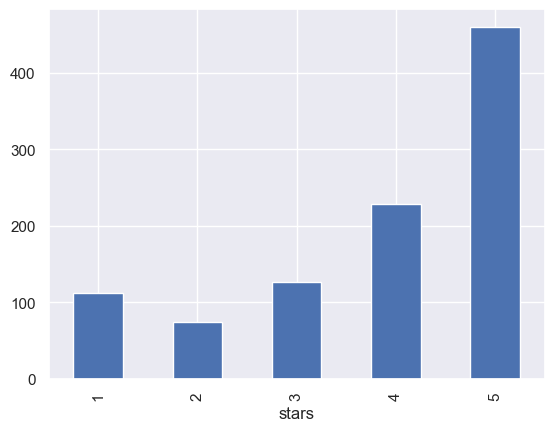

In [6]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar()

In [7]:
preview_dfs['business']['categories'].unique()[0:20]

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries',
       'Brewpubs, Breweries, Food',
       'Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants',
       'Sporting Goods, Fashion, Shoe Stores, Shopping, Sports Wear, Accessories',
       'Synagogues, Religious Organizations',
       'Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek',
       'Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food',
       'Department Stores, Shopping, Fashion',
       'Vietnamese, Food, Restaurants, Food Trucks',
       'American (Traditional), Restaurants, Diners, Breakfast & Brunch',
       'General Dentistry, Dentists, Health & Medic

In [8]:
review = preview_dfs['review']
for star in range(1,6):
    title = HTML(f'<h3 style="">Note = {star}<br><hr></h3>')
    display(title)
    for index in review[review['stars']==star].sample(2, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        quote = HTML(f'<div style="border-left: 4px solid yellow; padding-left:10px; margin-bottom:20px;">{text}</div>')
        display(quote)

<Axes: xlabel='class'>

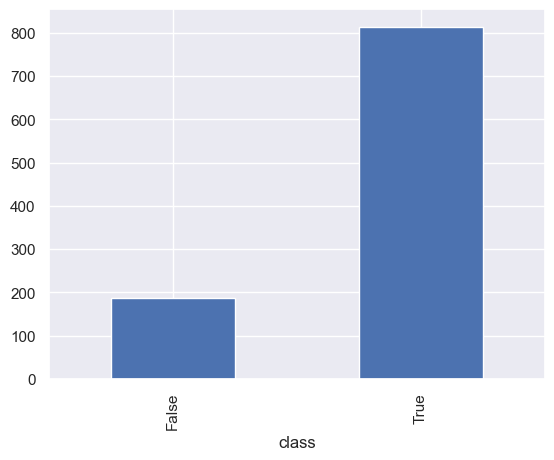

In [9]:
bad_stars = 2
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > bad_stars
preview_dfs['review']['class'].value_counts().sort_index().plot.bar()

In [10]:
sampling_coef_bad = preview_dfs['review']['class'].value_counts()[False]/preview_dfs['review']['class'].value_counts()[True]
print(f'{sampling_coef_bad*100:.0f}% des reviews ont au maximum {bad_stars} étoiles')

23% des reviews ont au maximum 2 étoiles


## Extraction d'un échantillons de reviews

### Recensement des catégories de business

In [11]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])
business['_cats'].sample(5)

105501    [Asian Fusion, Mexican, Caribbean, African, Cu...
94621     [Restaurants, Bubble Tea, Shaved Ice, Shaved S...
91304            [Pizza, Restaurants, Gluten-Free, Italian]
142455    [Hotels & Travel, Hotels, Event Planning & Ser...
29121     [Restaurants, Breakfast & Brunch, Cafes, Food,...
Name: _cats, dtype: object

In [12]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

In [13]:
[categorie for categorie in categories if 'restaurant' in categorie.lower()]

['Pop-Up Restaurants', 'Restaurant Supplies', 'Restaurants']

In [14]:
[categorie for categorie in categories if 'food' in categorie.lower()]

['Food Tours',
 'Fast Food',
 'Food Delivery Services',
 'Ethnic Food',
 'Seafood',
 'Food Banks',
 'Specialty Food',
 'Imported Food',
 'Food Trucks',
 'Comfort Food',
 'Food Court',
 'Soul Food',
 'Food',
 'Food Stands',
 'Do-It-Yourself Food',
 'Live/Raw Food',
 'Seafood Markets']

### Création des fichiers parquets

- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation par note
- Ajout des infos business
- Limite en quantité

In [15]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
print(f'{len(restaurants_ids)} business sont des Restaurants')

52268 business sont des Restaurants


In [16]:
reviews_files = {stars:WORK_DATASET_DIR + f'reviews_stars_{stars}.parquet' for stars in range(1,6)}
reviews_counts = {stars:0 for stars in range(1,6)}
reviews_append = {stars:False for stars in range(1,6)}

business['review_count_q'] = pd.qcut(business.review_count, q=4, labels=['c1', 'c2', 'c3', 'c4'])
if EXTRACT_PARQUET:
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=10000):
        restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
        restaurant_reviews = restaurant_reviews.join(business.set_index('business_id'), on='business_id', rsuffix='_business')

        for stars in reviews_counts:
            if reviews_counts[stars] < SAMPLING_REVIEW_SIZE:
                reviews = restaurant_reviews[restaurant_reviews['stars'] == stars]
                keep_rows = min(SAMPLING_REVIEW_SIZE - reviews_counts[stars], reviews.shape[0])
                reviews_counts[stars] = reviews_counts[stars] + keep_rows
                reviews.iloc[:keep_rows].to_parquet(reviews_files[stars], engine='fastparquet', append=reviews_append[stars])
                reviews_append[stars] = True

        if sum([reviews_counts[i] for i in reviews_counts]) == SAMPLING_REVIEW_SIZE*len(reviews_counts): break

def get_reviews(max_stars = 2, stars = None):
    if stars:
        return pd.read_parquet(reviews_files[stars])
        
    df = pd.DataFrame()
    for stars in range(1, max_stars + 1):
        df = pd.concat([df, pd.read_parquet(reviews_files[stars])])
    return df

In [17]:
print(f'Exemple de dataFrame contenant les enregistrements qui ont au maximum {bad_stars} étoiles')
get_reviews(max_stars=bad_stars).sample(5)

Exemple de dataFrame contenant les enregistrements qui ont au maximum 2 étoiles


review_id                 user_id             business_id  \
index                                                                           
8619   86Gdv9iIjnpJNZ0Z8BjWjg  64ycR7b17rOGsBr4d3Ll_w  C0j0V6dtOK2Q0OZLTs-Y3g   
5551   wKL4szLUXAikz5x-x5I_Ow  k8AGvMXf3qAmPhZlV6I3LA  EpREWeEpmR8f1qLHzzF0AA   
8863   UIiBd9vtm8cADWVA5sGpUg  hFtqG0rR7b0IoCeijyxM-g  VJEzpfLs_Jnzgqh5A_FVTg   
12310  -gpfmt1SyZvFDjWb5IXfEA  bsxHpxxT7UwtLcRl9UntAg  1IjHo5kaSdFxJkJotU4O7A   
11087  ejVLfVPfwYEcbtyH9NH7TQ  qYRIZeyIyA1YIGsV4qUdQw  o1XFkEB34jUry4Vk_L1xdg   

       stars  useful  funny  cool  \
index                               
8619       1       0      0     0   
5551       2       0      0     0   
8863       2       0      0     0   
12310      2       4      2     0   
11087      2       0      0     0   

                                                    text                date  \
index                                                                          
8619   The worst customer service and nasty employees... 2016-05-21 18:50:05   
5551   "I'll get to you when I can"-- Not the best wa... 2015-07-03 21:37:02   
8863   We went there yesterday based on the (mostly g... 2015-11-18 22:54:59   
12310  I'm giving this review for a few VERY specific... 2018-08-20 15:59:28   
11087  Reasonable price for seafood, but not to die f... 2017-03-04 03:11:26   

                                    name  ...   latitude   longitude  \
index                                     ...                          
8619                            Checkers  ...  39.833101  -75.005410   
5551                Schlafly Bottleworks  ...  38.613090  -90.314761   
8863          Jasmine Rice - Rittenhouse  ...  39.947084  -75.168205   
12310  Sociale Italian Tapas & Pizza Bar  ...  27.884430  -82.486270   
11087                   Joe's Crab Shack  ...  43.620800 -116.232737   

      stars_business review_count  is_open  \
index                                        
8619             2.5           15        0   
5551             4.0          615        1   
8863             3.5          307        1   
12310            4.0          125        0   
11087            3.0          141        1   

                                              attributes  \
index                                                      
8619   b'{"RestaurantsTakeOut":"True","NoiseLevel":"\...   
5551   b'{"BusinessAcceptsCreditCards":"True","BikePa...   
8863   b'{"RestaurantsPriceRange2":"2","RestaurantsAt...   
12310  b'{"ByAppointmentOnly":"False","HappyHour":"Tr...   
11087  b'{"BusinessParking":"{\'garage\': False, \'st...   

                                              categories  \
index                                                      
8619                     Restaurants, Fast Food, Burgers   
5551   Local Flavor, Food, Brewpubs, Breweries, Resta...   
8863                      Soup, Thai, Restaurants, Salad   
12310  Restaurants, Cocktail Bars, Italian, Nightlife...   
11087  American (Traditional), Restaurants, Seafood, ...   

                                                   hours  \
index                                                      
8619   b'{"Monday":"10:0-1:0","Tuesday":"10:0-1:0","W...   
5551   b'{"Wednesday":"11:0-21:0","Thursday":"11:0-21...   
8863   b'{"Monday":"13:30-22:30","Tuesday":"13:30-22:...   
12310  b'{"Monday":"16:0-21:0","Tuesday":"16:0-21:0",...   
11087  b'{"Monday":"11:0-21:0","Tuesday":"11:0-21:0",...   

                                                   _cats review_count_q  
index                                                                    
8619            b'["Restaurants","Fast Food","Burgers"]'             c2  
5551   b'["Local Flavor","Food","Brewpubs","Breweries...             c4  
8863            b'["Soup","Thai","Restaurants","Salad"]'             c4  
12310  b'["Restaurants","Cocktail Bars","Italian","Ni...             c4  
11087  b'["American (Traditional)","Restaurants","Sea...             c4  

[5 rows x 24 columns]

## Analyse des echantillons de reviews 

### Fonctions de traitement du text

In [18]:
def get_negative_sw():
    return [sw for sw in stopwords.words('english') if sw not in ['not', 'too', 'very', 'few',  "don't", "aren't", 'couldn',
                                                                  "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                                  "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
                                                                  "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
                                                                  "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                                                                  "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
           ]

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    # normalization
    text = text.lower().strip()

    return text 

def tokenize(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    # Keep tokens with length > 2
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

def extract_n_grams(token_list, n_list):
    import nltk
    n_grams = []
    for n in n_list:
        n_grams.append([' '.join(n_gram) for n_gram in nltk.ngrams(token_list,n)])

    new_token_list = []
    for n_gram in n_grams:
        new_token_list  = new_token_list + n_gram

    if 1 in n_list:
        new_token_list = token_list + new_token_list

    return new_token_list    
    
def display_word_cloud(reviews, no_below = 4, no_above = 0.1, max_words_in_cloud=50, verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')

    if verbose > 0: display(reviews.sample(5, random_state=0).loc[:, ['stars', 'text']])
    
    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=(verbose > 0), verbose=False)
    
    # Preprocess
    if verbose > 0: print('\nPreprocess\n=================\n')
    reviews['text'] = reviews['text'].parallel_apply(preprocess_text)

    # Preprocess (tokenize, lemmatization)
    if verbose > 0: print('\nTokenize\n=================\n')
    reviews['tokens'] = reviews['text'].parallel_apply(tokenize)
    reviews.drop(columns=['text'], inplace=True)

    stop_words = get_negative_sw()
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(stop_words,))
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()

    if verbose > 0:
        print('')
        tokens_infos = [
            ['Nombre de tokens unique initial dans le dataframe', nb_words_original],
            ['Nombre de stopwords', len(stop_words)],
            ['Nombre de tokens unique restant dans le dataframe', len(set(reviews['tokens'].sum()))]
        ]
        print(tabulate(tokens_infos))

    # View result sample
    if verbose > 0: 
        print('\nEchantillon du resultat\n=================\n')
        display(reviews.sample(5, random_state=0).loc[:, ['stars', 'tokens']])

    # Calc and view text lengths
    if verbose > 0: 
        print('\nAnalyse des longeurs de text\n=================\n')
        reviews.boxplot(column='text_len', showfliers=True, vert=False)
        plt.show()

    # Text length
    total_text_len = reviews['text_len'].sum()
    if verbose > 0: 
        print(f'Longeur total du texte dans le dataframe: {total_text_len}')
        print('')

    # Visualisation Word clound on sample
    # Sampling for word cloud
    cloud_sample_size = min(reviews.shape[0], 1000)
    sample = reviews.sample(cloud_sample_size, random_state=0)['tokens']

    # Filter extremes filter
    dictionary = corpora.Dictionary(list(sample))
    dictionary.filter_extremes(no_below=2, no_above=0.1)
    sample.parallel_apply(lambda tokens: [token for token in tokens if token in list(dictionary.values())])
    
    if verbose > 0: print(f'\nVisualisation du nuage de mot d\'un échantillon de {cloud_sample_size} lignes\n=================\n')

    # Join text and display wordcloud
    sample_text = ' '.join(sample.str.join(' ').values)
    wordcloud = WordCloud(background_color = 'white', max_words = max_words_in_cloud).generate(sample_text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();
    print('')

### Nuages de mots par note

Note = 5


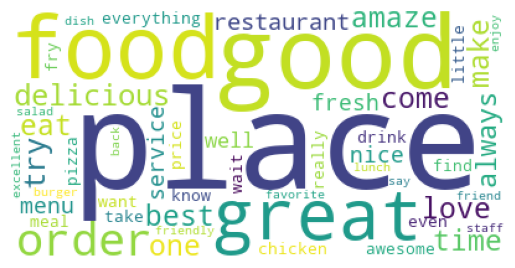


Note = 4


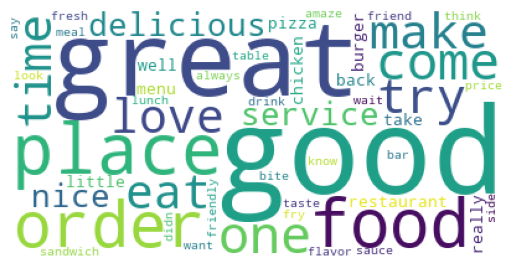


Note = 3


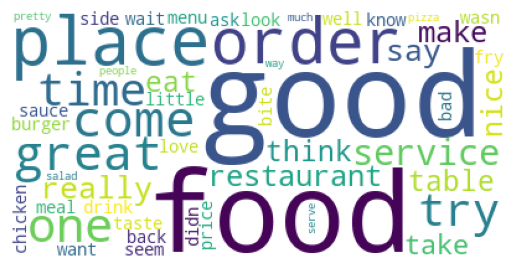


Note = 2


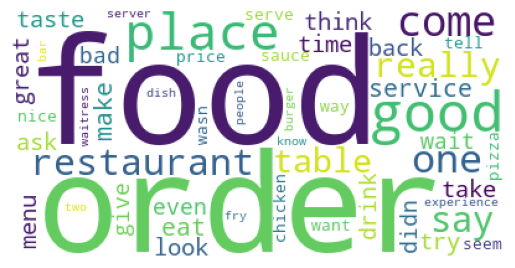


Note = 1


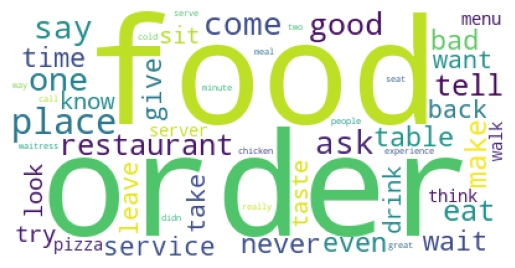

In [20]:
for stars in range(5,0,-1):
    print(f'Note = {stars}')
    display_word_cloud(reviews=get_reviews(stars=stars),
                       no_below=2,
                       no_above= 0.1, 
                       max_words_in_cloud=50)

## Recherche des sujets d'insatisfactions

### Sac de mots (TF-IDF)

In [21]:
def tf_idf(reviews, min_df = 4, max_df = 100, ngram_range=(1,2), verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')
    
    if verbose > 1: display(reviews.sample(5, random_state=0))


    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words=get_negative_sw(), sublinear_tf=True,ngram_range=ngram_range)
    values = vectorizer.fit_transform(reviews['text'])

    if verbose > 0:
        print('\nVecteurs TF-IDF des reviews:\n====================')
        df = pd.DataFrame(values.toarray(), columns=vectorizer.get_feature_names_out())
        display(df.head())
        
        reviews_vecteurs = []
        reviews.reset_index(inplace=True)
        for index in reviews[reviews['text'].str.len() < 500].sample(5, random_state=0).index:
            review_tfidf = df.iloc[index][df.iloc[index] > 0].to_dict()
            reviews_vecteurs.append([reviews.iloc[index]['text'] , '\n'.join([f'{token}: {tfidf:.4f}' for token, tfidf in review_tfidf.items()])])
        print(tabulate(reviews_vecteurs, headers=['text review', 'vecteur tf-idf'], tablefmt="grid", maxcolwidths=[100, None]))

    return values, vectorizer.get_feature_names_out()

In [22]:
print(f'Vectorisation pour les reviews comportant maximum {bad_stars} étoiles')
reviews = get_reviews(max_stars=bad_stars)
values, features_names = tf_idf(reviews=reviews,
                                min_df=10,
                                max_df=0.1,
                                ngram_range=(1,2),
                                verbose=1)

Vectorisation pour les reviews comportant maximum 2 étoiles
Nombre de textes dupliqués supprimés: 0
Il y a 2000 enregistrements

Vecteurs TF-IDF des reviews:


100  1st  2nd  able  absolute  absolutely  accept  accommodate  \
0  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
1  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
2  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
3  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
4  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   

   acknowledge  across  ...  yelp       yes  yesterday  yet  york  young  \
0          0.0     0.0  ...   0.0  0.231769        0.0  0.0   0.0    0.0   
1          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
2          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
3          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
4          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   

   yuck  yummy      zero  zero star  
0   0.0    0.0  0.000000        0.0  
1   0.0    0.0  0.000000        0.0  
2   0.0    0.0  0.176228        0.0  
3   0.0    0.0  0.000000        0.0  
4   0.0    0.0  0.000000        0.0  

[5 rows x 1901 columns]

+------------------------------------------------------------------------------------------------------+--------------------------+
| text review                                                                                          | vecteur tf-idf           |
+======================================================================================================+==========================+
| You don't accept cash?  I don't think you grasp the ramifications of such a corpo-fascist economic   | accept: 0.2965           |
| principle.  No room for arrogant commies in my diet thank you so very very little.  Can't wait to    | anyone: 0.2395           |
| see this place nosedive  For anyone in the dark about this policy,  watch Mike Judge's film,         | attention: 0.2499        |
| Idiocracy. Pay close attention throughout the hospital scene.   "Unscannable!!!"                     | cash: 0.2758             |
|                                                                           

### LDA Librairie Sklean

In [23]:
def get_topics(reviews: pd.DataFrame, min_df = 4, max_df = 10, n_topics = 10, alpha = 10, n_top_words = 10, ngram_range=(1,1), verbose = 0):

    # pandas width
    pd_width = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 300)
    
    if verbose > 1: print('  - Vectorisation (tf-idf)')
    values, features_names = tf_idf(reviews=reviews, min_df=min_df, max_df=max_df, ngram_range=ngram_range, verbose = 0)

    # Topics from LDA or MDF
    if verbose > 1: print('  - Modélisation LDA')
    model = LatentDirichletAllocation(n_components=n_topics,
                                      max_iter=10,
                                      doc_topic_prior=alpha,
                                      learning_method='online', 
                                      learning_offset=10,
                                      random_state=0,
                                      n_jobs=-1)
    
    model.fit(values)

    if verbose > 1: print('  - Affichage des topics\n')
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        features = [features_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([topic_idx, ', '.join(features)])
    
    if verbose > 0: print(tabulate(topics, headers=['Topic n°', 'Categories']))

    # Restore pandas width
    pd.set_option('display.max_colwidth', pd_width)

    return topics

In [24]:
params = {
    'max_stars': bad_stars,
    'min_df': 2,
    'max_df': 0.1,
    'n_topics': 5,
    'alpha': 0.5,
    'n_top_words': 5,
    'ngram_range': (1,1)
}

print(f'Recherche des sujets avec les paramètres suivants:\n')
print(tabulate([[name, value] for name, value in params.items()], headers=['param', 'valeur']))
print('')
topics = get_topics(reviews=get_reviews(max_stars=bad_stars),
                    min_df=params['min_df'],
                    max_df=params['max_df'],
                    n_topics=params['n_topics'], 
                    alpha=params['alpha'],
                    n_top_words=params['n_top_words'],
                    ngram_range=params['ngram_range'],
                    verbose=3)

Recherche des sujets avec les paramètres suivants:

param        valeur
-----------  --------
max_stars    2
min_df       2
max_df       0.1
n_topics     5
alpha        0.5
n_top_words  5
ngram_range  (1, 1)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  --------------------------------------------
         0  pizza, waitress, burger, sauce, bar
         1  mahi, gun, trio, uncooked, surly
         2  donut, fancy, bueno, wifi, liver
         3  refer, 312, denny, tony, angelo
         4  initially, expense, goopy, preference, legit


In [25]:
params['alpha'] = 0.2
params['max_df'] = 0.2
params['ngram_range'] = (3,3)

print(f'Recherche des sujets avec les paramètres suivants:\n')
print(tabulate([[name, value] for name, value in params.items()], headers=['param', 'valeur']))
print('')
topics = get_topics(reviews=get_reviews(max_stars=bad_stars),
                    min_df=params['min_df'],
                    max_df=params['max_df'],
                    n_topics=params['n_topics'], 
                    alpha=params['alpha'],
                    n_top_words=params['n_top_words'],
                    ngram_range=params['ngram_range'],
                    verbose=3)

Recherche des sujets avec les paramètres suivants:

param        valeur
-----------  --------
max_stars    2
min_df       2
max_df       0.2
n_topics     5
alpha        0.2
n_top_words  5
ngram_range  (3, 3)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  -------------------------------------------------------------------------------------------
         0  would not recommend, waste time money, food good not, not recommend place, not impress food
         1  service very slow, not worth price, make feel like, food not good, food pretty good
         2  food nothing special, get money back, way too much, nothing write home, happy hour menu
         3  take minute get, never come back, would give star, take forever get, give place another
         4  not very good, want like place, not worth wait, really want like, wait another minute


### LDA Librairie Gensim et optimisation du nombre de sujets

In [26]:
def prepare_data(max_stars=2, n_grams=[1,2], no_below=2, no_above=0.1):
    print('  - Préparation des data (preprocess tokenisation...)')

    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=False, verbose=False)
    
    # Preprocess, tokenize and drop stop words
    reviews = get_reviews(max_stars=max_stars)
    texts = reviews['text'].parallel_apply(preprocess_text)
    texts = texts.parallel_apply(tokenize)
    stop_words = get_negative_sw()
    texts = texts.parallel_apply(drop_words, args=(stop_words,))
    
    # Managing n_grams
    texts = texts.parallel_apply(extract_n_grams, args=(n_grams,))

    # list texts
    texts = list(texts)
    
    # create document terms matrix
    dictionary = corpora.Dictionary(texts)
    
    #filter extremes
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    
    corpus = [dictionary.doc2bow(text) for text in texts]

    return texts, dictionary, corpus

def modelize(dictionary, corpus, alpha = 10, num_topics = 10):
    print(f'  - LDA pour {num_topics} topics')
    LDA = gensim.models.ldamodel.LdaModel
    model = LDA(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha, random_state=0, chunksize=1000, passes=50,iterations=100)
    return model

def visualize_model(model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis

def print_topics(model):
    topics = []
    for topic in model.show_topics():
        index = topic[0] + 1
        terms = '\n'.join(topic[1].split(' + '))
        topics.append([index, terms])
    
    print(tabulate(topics, headers=['Topic n°', 'mots clés'], tablefmt="grid"))

In [27]:
texts, dictionary, corpus = prepare_data(max_stars=2, n_grams=[2,3], no_below=2, no_above=0.2)
model = modelize(dictionary=dictionary, corpus=corpus, num_topics=5)
print_topics(model)
vis = visualize_model(model, corpus, dictionary)
vis

  - Préparation des data (preprocess tokenisation...)
  - LDA pour 5 topics
+------------+--------------------------+
|   Topic n° | mots clés                |
+============+==========================+
|          1 | 0.005*"come back"        |
|            | 0.004*"taste like"       |
|            | 0.003*"win back"         |
|            | 0.002*"food not"         |
|            | 0.002*"wait staff"       |
|            | 0.002*"felt like"        |
|            | 0.002*"every time"       |
|            | 0.002*"mac cheese"       |
|            | 0.002*"fast food"        |
|            | 0.002*"mexican food"     |
+------------+--------------------------+
|          2 | 0.004*"look like"        |
|            | 0.003*"not return"       |
|            | 0.003*"even though"      |
|            | 0.002*"not sure"         |
|            | 0.002*"good place"       |
|            | 0.002*"good thing"       |
|            | 0.002*"mash potato"      |
|            | 0.002*"like place"       |


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.148311 -0.097005       1        1  20.580602
0     -0.042849  0.052653       2        1  20.199006
4      0.112615  0.179835       3        1  19.898471
1      0.174361 -0.167906       4        1  19.864944
3     -0.095815  0.032423       5        1  19.456976, topic_info=            Term       Freq       Total Category  logprob  loglift
703    last time  36.000000   36.000000  Default  30.0000  30.0000
139   first time  67.000000   67.000000  Default  29.0000  29.0000
2046  last night  36.000000   36.000000  Default  28.0000  28.0000
97    taste like  95.000000   95.000000  Default  27.0000  27.0000
335    look like  56.000000   56.000000  Default  26.0000  26.0000
...          ...        ...         ...      ...      ...      ...
169     food not  17.790611   52.310818   Topic5  -6.3650   0.5584
71      get food  17.468364   61.615343   Topic5  -6.3833   0.3764
112    didn even  16.063440   43.468065   Topic5  -6.4671   0.6415
63     come back  17.554189  121.905557   Topic5  -6.3784  -0.3010
175     not even  14.987818   48.038690   Topic5  -6.5364   0.4722

[328 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1800      5  0.931457    almost hour
1546      1  0.905917  almost minute
4231      2  0.975567    another try
3677      5  0.918649      ask order
2721      1  0.907344     ask waiter
...     ...       ...            ...
1037      2  0.019768      would not
1037      4  0.019768      would not
1037      5  0.652330      would not
3038      3  0.073455    would think
3038      4  0.881458    would think

[536 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 4])

In [28]:
texts, dictionary, corpus = prepare_data(max_stars=1, n_grams=[3], no_below=2, no_above=0.1)
model = modelize(dictionary=dictionary, corpus=corpus, alpha=20, num_topics=5)
print_topics(model)
vis = visualize_model(model, corpus, dictionary)
vis

  - Préparation des data (preprocess tokenisation...)
  - LDA pour 5 topics
+------------+-----------------------------------+
|   Topic n° | mots clés                         |
+============+===================================+
|          1 | 0.012*"waste time money"          |
|            | 0.011*"never come back"           |
|            | 0.009*"get money back"            |
|            | 0.009*"buy one get"               |
|            | 0.008*"could give zero"           |
|            | 0.008*"would not recommend"       |
|            | 0.008*"take drink order"          |
|            | 0.007*"excite try place"          |
|            | 0.007*"give another chance"       |
|            | 0.007*"come back check"           |
+------------+-----------------------------------+
|          2 | 0.009*"want like place"           |
|            | 0.009*"make eye contact"          |
|            | 0.008*"wish could give"           |
|            | 0.008*"say didn know"             |
|     

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.108142  0.122379       1        1  20.038914
0      0.090220  0.020157       2        1  20.034222
3     -0.078216 -0.038631       3        1  19.990336
4     -0.023514 -0.145471       4        1  19.976336
2      0.119652  0.041566       5        1  19.960192, topic_info=                   Term      Freq      Total Category  logprob  loglift
196      new york pizza  4.000000   4.000000  Default  30.0000  30.0000
385         buy one get  4.000000   4.000000  Default  29.0000  29.0000
570    make eye contact  4.000000   4.000000  Default  28.0000  28.0000
225       take one bite  4.000000   4.000000  Default  27.0000  27.0000
83       get money back  4.000000   4.000000  Default  26.0000  26.0000
..                  ...       ...        ...      ...      ...      ...
214       give one star  1.885276   4.959254   Topic5  -5.3609   0.6442
205      taste like old  1.644789   3.553527   Topic5  -5.4973   0.8411
63      never come back  1.876603  12.071961   Topic5  -5.3655  -0.2500
703  food great service  1.589953   2.839388   Topic5  -5.5313   1.0315
281    call place order  1.572935   2.843788   Topic5  -5.5420   1.0192

[259 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
510       5  0.938971   actually get eat
147       2  0.939828  almost hour drink
71        2  0.939824       ask girl add
182       1  0.176013  ask speak manager
182       3  0.352026  ask speak manager
...     ...       ...                ...
542       3  0.701632   wouldn come back
115       4  0.938682   write bad review
195       2  0.200893    zero star would
195       3  0.200893    zero star would
195       4  0.602678    zero star would

[320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 3])

# Classifications des images

## Prévisualisation du dataset

In [29]:
df_photos = pd.read_json('data/original/yelp_photos/photos.json', lines=True)
df_photos.sample(5)

photo_id             business_id  \
34527   nikzk_1szA2CFL1KNcUGcA  WhTRPUduXy3mRBYlmSmsKw   
103388  REH6BMvATFE-FdgVT_EJYg  2DTkzhmMpv5fIPKheePClA   
116575  1WJG8KUCnlw2Thsbo9DhuA  EB56UJGZclhx9y5c7VMfFQ   
196309  7IZsp5j6EYtcYULQibbabQ  jWsZ4M0g6ViLdJKRM73C8w   
183846  iSdU_wkgUkg7gsv3fAdK0Q  yvFuvPu5Ebv2LXv59RJSIg   

                                                  caption    label  
34527   Interior. Ask for some Free Samples. It's hard...   inside  
103388              Whole roasted cauliflower and falafel     food  
116575                                                     outside  
196309                                                        food  
183846                                                        food

In [30]:
df_photos.shape

(200100, 4)

In [31]:
df_photos.label.value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

## Creation dataset echantillons

L'échantillon contient 500 images


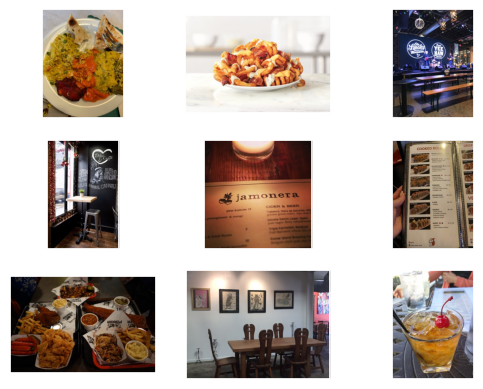

In [32]:
def get_original_photo_path(photo_id):
    return ORIGINAL_PHOTOS_DIR + 'photos/' + photo_id + '.jpg'
    
photo_ids = {}
df_photos_sampling = pd.DataFrame()
for label in df_photos.label.unique():
    photo_ids = list(df_photos[df_photos.label == label].sample(SAMPLING_PHOTOS_SIZE, random_state=0)['photo_id'])
    df_label = pd.DataFrame({
        'photo_id': photo_ids,
        'label': np.full(len(photo_ids), label),
        'width': np.zeros(len(photo_ids)), 
        'height': np.zeros(len(photo_ids)), 
        'mode': np.full(len(photo_ids), '')
    })
    df_photos_sampling = pd.concat([df_photos_sampling, df_label], ignore_index=True)

label_encoder = LabelEncoder()
df_photos_sampling['label_num'] = label_encoder.fit_transform(df_photos_sampling['label'])

print(f'L\'échantillon contient {df_photos_sampling.shape[0]} images')

sample_ids = list(df_photos_sampling.sample(9, random_state=1)['photo_id'])
for i in range(9):
    plt.subplot(330 + 1 + i)
    image = matplotlib.image.imread(get_original_photo_path(sample_ids[i]))
    plt.imshow(image)
    plt.grid(linewidth=0)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.show()

In [33]:
def fill_infos(df):
    for index in df.index:
        print(f'Lecture infos image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        img = Image.open(get_original_photo_path(photo_id))
        
        w, h = img.size
        df.loc[df['photo_id']==photo_id, 'height'] = h   
        df.loc[df['photo_id']==photo_id, 'width'] = w
        df.loc[df['photo_id']==photo_id, 'mode'] = img.mode

fill_infos(df_photos_sampling)
df_photos_sampling.sample(5)

photo_id   label  width  height mode  label_num
460  -bBz2HHkzz1-5e-gPCgN8g    menu  600.0   337.0  RGB          3
51   Gl7iExBEXudvs5zkPfmoCA  inside  300.0   400.0  RGB          2
254  ALMglZtu2o4Jncj5mQZXKQ   drink  400.0   400.0  RGB          0
6    m5iAcgiPxWqGrdhwclUgMA  inside  600.0   399.0  RGB          2
440  3UOTs5KNs6qxW3gXwBedNg    menu  533.0   400.0  RGB          3

In [34]:
df_photos_sampling.describe()

width      height  label_num
count  500.000000  500.000000  500.00000
mean   438.882000  389.688000    2.00000
std    131.985303   32.814085    1.41563
min    131.000000   69.000000    0.00000
25%    300.000000  400.000000    1.00000
50%    408.000000  400.000000    2.00000
75%    543.750000  400.000000    3.00000
max    600.000000  400.000000    4.00000

In [35]:
df_photos_sampling['mode'].value_counts()

mode
RGB    500
Name: count, dtype: int64

## Clustering par descripteurs SIFT

In [54]:
df_sift = df_photos_sampling.copy()

### Pretraitement des images

In [55]:
def preprocess_images_sift(df):
    for index in df.index:
        print(f'preprocess image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        preprocess_image_sift(photo_id)

def preprocess_image_sift(photo_id, display_evo = False):
    original_path = get_original_photo_path(photo_id)
    if display_evo:
        img = display_img(original_path)
        img = histo_rgb(img)
    else:
        img = Image.open(original_path)
    
    img = treat_histogram(img)
    img = filter_img(img)
    new_path = save_img(current_path=original_path, img=img, work_part='sift')

    if display_evo:
        img = display_img(new_path)
        img = histo_rgb(img)
    
    return new_path
    
def display_img(path):
    img = Image.open(path)
    display(img)
    return img

def histo_rgb(img):
    r, g, b = img.split()
    fig, axs = plt.subplots(1,3, figsize=(10,5), sharey=True)
    chans = {'rouge': r, 'vert': g, 'bleu':b}
    for index, name in enumerate(chans):
        chan_flat = np.array(chans[name]).flatten()
        ax = sns.histplot(chan_flat, bins=range(256), ax=axs[index])
        ax.set(ylabel=None,
               title=f'Channel: {name}')
    fig.supxlabel('Intensité')
    fig.supylabel('Nombre de pixels')
    plt.show()

    return img

def treat_histogram(img):
    # Equalize and autocontrast
    img = ImageOps.equalize(img)
    img = ImageOps.autocontrast(img)
    return img
    

def filter_img(img):
    # Apply gaussian blur
    img = img.filter(ImageFilter.MedianFilter(size=3))
    return img

def save_img(current_path, img, work_part):
    filename = os.path.basename(current_path)
    new_path = WORK_PHOTOS_DIR + work_part + '/' + filename
    img.save(new_path)

    return new_path

#### Exemple de pre-traitement

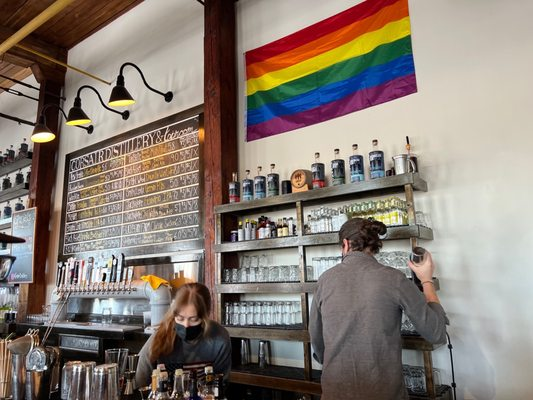

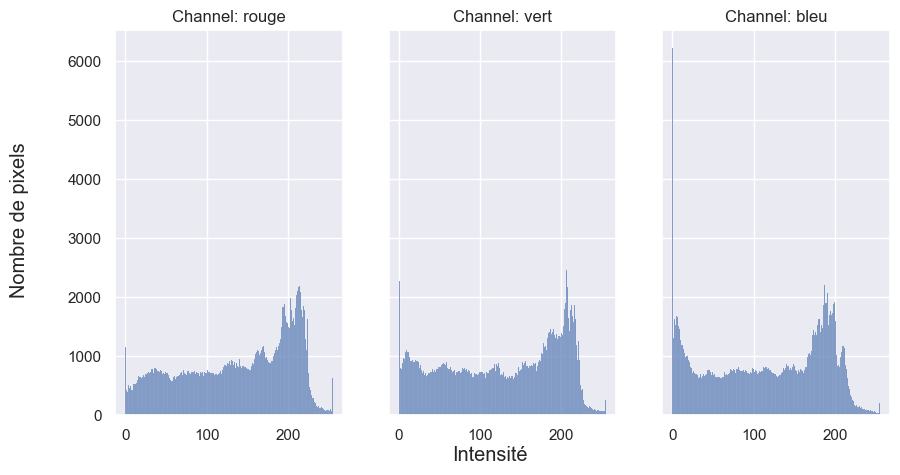

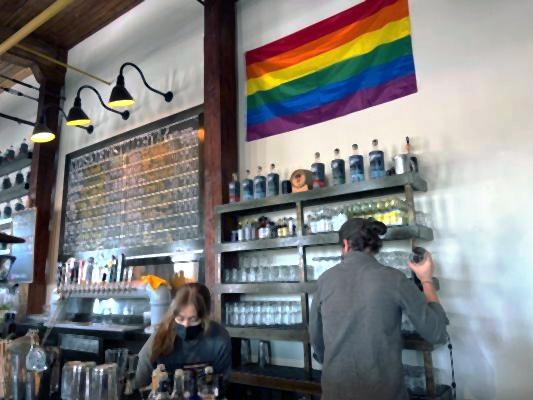

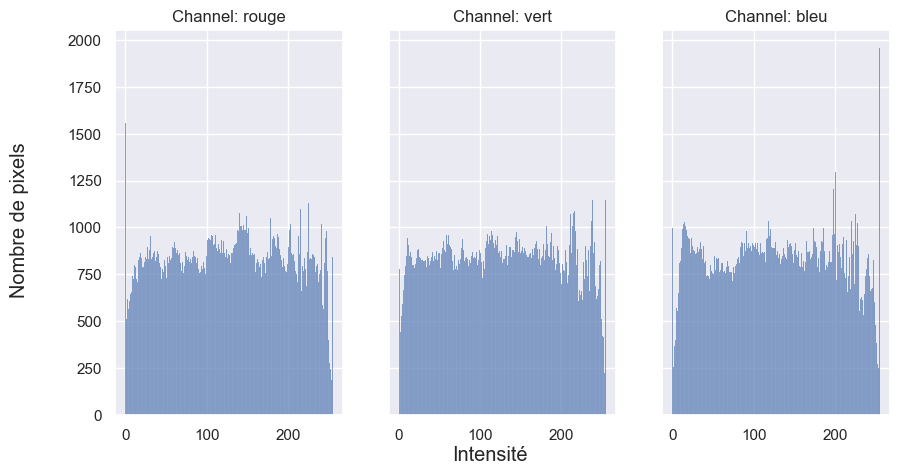

'data/work/yelp_photos/sift/1KfbK9IcrbxY1lUkvN1aUA.jpg'

In [56]:
photo_id_sample = df_sift.sample(1, random_state=0)['photo_id'].iloc[0]
preprocess_image_sift(photo_id_sample,display_evo=True)

#### Pretaitement de l'ensemble de l'échantillon

In [57]:
if PREPROCESS_IMAGES:
    preprocess_images_sift(df=df_sift)

### Creation des descripteurs

In [58]:
def get_descripteurs(photo_id, max_desc=500, work_dir = WORK_PHOTOS_DIR, plot = False, print_desc = False):
    import cv2
    sift = cv2.xfeatures2d.SIFT_create(max_desc)
    image = cv2.imread(work_dir + 'sift/' + photo_id + '.jpg')
    kp, desc = sift.detectAndCompute(image, None)

    if plot:
        img=cv2.drawKeypoints(image,kp,image)
        plt.imshow(img)
        plt.grid(linewidth=0)
        plt.show()

    if print_desc:
        print("Descripteurs : ", desc.shape)
        print()
        print(desc)
    
    return desc    

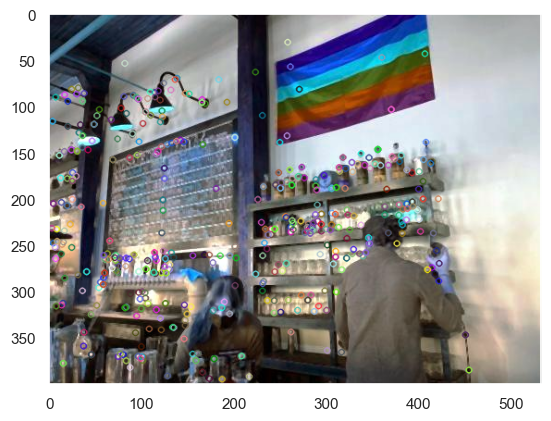

Descripteurs :  (501, 128)

[[ 0.  0.  0. ...  1. 18. 18.]
 [13. 14.  8. ... 24.  0.  1.]
 [24.  0.  0. ...  2.  5. 25.]
 ...
 [ 0.  0.  0. ...  0.  2.  8.]
 [ 0.  0.  0. ...  0.  2. 13.]
 [ 0.  0. 10. ...  0.  0. 12.]]


In [59]:
desc = get_descripteurs(photo_id=photo_id_sample, plot=True, print_desc=True)

In [60]:
pandarallel.initialize(progress_bar=True, verbose=False)
descripteurs = df_sift['photo_id'].parallel_apply(get_descripteurs, args=(500,))
df_sift['desc'] = descripteurs
display(df_sift.sample(3))
num_img_desc = df_sift['desc'][0].shape[0]

photo_id    label  width  height mode  label_num  \
135  iXR9gL79d-_UlQyDae3XJQ  outside  300.0   400.0  RGB          4   
77   1ETHp_yIPxACo5Mn4rdsYQ   inside  533.0   400.0  RGB          2   
105  3v0y2ErERcJFwJk2YN9Xag  outside  533.0   400.0  RGB          4   

                                                  desc  
135  [[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 46.0, 3....  
77   [[0.0, 10.0, 10.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0....  
105  [[10.0, 94.0, 105.0, 7.0, 3.0, 1.0, 0.0, 1.0, ...

### Clustering des descripteurs

In [61]:
all_descripteurs = np.concatenate(df_sift['desc'].values, axis=0)
n_clusters = math.floor(math.sqrt(len(all_descripteurs)))
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=512, random_state=0, n_init="auto").fit(all_descripteurs)
print(f'Il y a {n_clusters} clusteurs pour un total de {len(all_descripteurs)} descripteurs')

Il y a 494 clusteurs pour un total de 244744 descripteurs


### Creations des features des images

In [62]:
def features_sift(descripteurs, kmeans: MiniBatchKMeans):
    import numpy as np
    desc_clusters = kmeans.predict(descripteurs)
    return np.histogram(desc_clusters, bins=kmeans.n_clusters, range=(0, kmeans.n_clusters))[0]

features = df_sift['desc'].parallel_apply(features_sift, args=(kmeans,))
df_sift['features'] = features
df_sift.sample(3)

photo_id   label  width  height mode  label_num  \
71   P3i_XzoEPHrwMnRHAlogLg  inside  300.0   400.0  RGB          2   
57   nELjR3KjGulASoJyys1JHw  inside  600.0   400.0  RGB          2   
213  PHTxRTwI9PNl1fav2afnmw   drink  600.0   400.0  RGB          0   

                                                  desc  \
71   [[30.0, 36.0, 18.0, 62.0, 22.0, 3.0, 0.0, 0.0,...   
57   [[147.0, 8.0, 0.0, 0.0, 14.0, 2.0, 0.0, 3.0, 6...   
213  [[0.0, 0.0, 0.0, 0.0, 0.0, 30.0, 40.0, 1.0, 0....   

                                              features  
71   [0, 1, 1, 0, 0, 1, 4, 1, 0, 0, 1, 5, 0, 5, 1, ...  
57   [0, 1, 2, 0, 1, 0, 2, 0, 1, 9, 0, 2, 0, 1, 1, ...  
213  [2, 1, 0, 1, 2, 0, 2, 0, 3, 10, 1, 0, 0, 4, 0,...

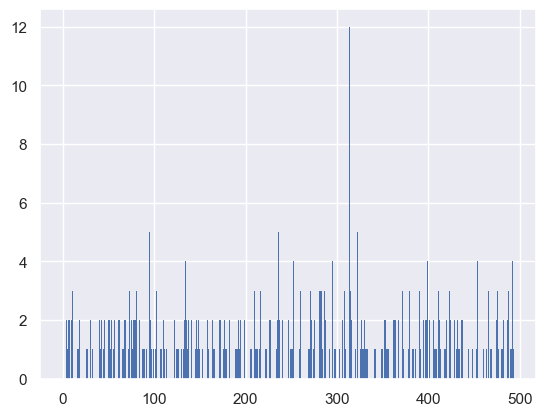

In [63]:
features_sample = df_sift['features'][0]
plt.bar(range(len(features_sample)), features_sample, linewidth=0)
plt.show()

### Reduction de dimension

In [64]:
def reduc_feature_dim(df):
    # Step1: PCA
    keep_variance = 0.99
    pca = PCA(n_components=keep_variance, svd_solver='full')
    features_pca = pca.fit_transform(list(df['features']))
    old_shape = df['features'][0].shape[0]
    new_shape = features_pca.shape[1]
    print(f'En concervant {keep_variance*100}% de la variance, la PCA réduit les features de {old_shape} composantes à {new_shape} composantes') 

    # Step2 TSNE
    tsne = TSNE(n_components=2, perplexity=20, n_iter=15000, init='random', random_state=0)
    X_tsne = tsne.fit_transform(features_pca)
    
    df['x_tsne'] = X_tsne[:,0:1]
    df['y_tsne'] = X_tsne[:,1:2]
    
    sns.scatterplot(df, x='x_tsne', y='y_tsne', hue='label')

    return df

En concervant 99.0% de la variance, la PCA réduit les features de 494 composantes à 343 composantes


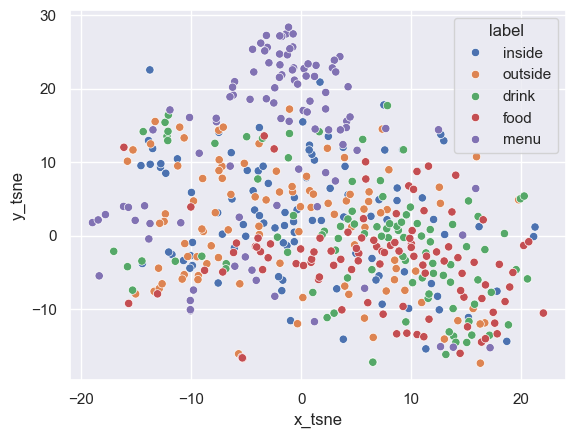

In [65]:
df_sift = reduc_feature_dim(df_sift)

### Clustering

In [89]:
def clustering(df):
    n_clusters = df['label'].nunique()
    X = np.array([df['x_tsne'], df['y_tsne']]).T
    kmean_final = MiniBatchKMeans(n_clusters=5, batch_size=512, random_state=0, n_init="auto").fit(X)
    images_clusters = kmean_final.predict(X)
    df['predict_clusters'] = images_clusters

    sns.scatterplot(df, x='x_tsne', y='y_tsne', hue='predict_clusters')

    conf_mat = confusion_matrix(list(df['label_num']), images_clusters)
    plt.figure(figsize = (6,4))
    sns.heatmap(conf_mat, annot=True, cmap="Blues", yticklabels=label_encoder.classes_)

    return df

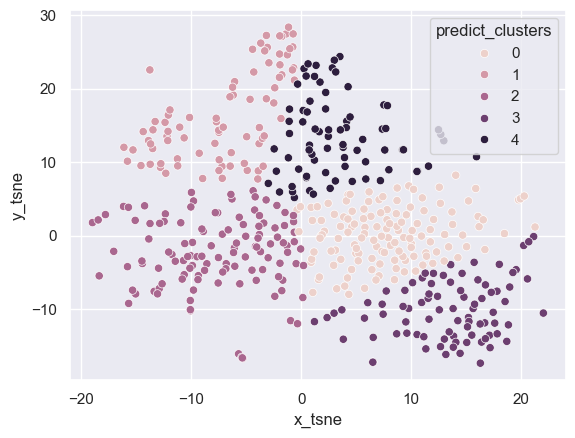

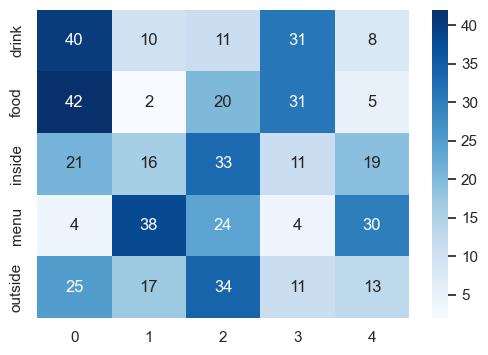

In [90]:
df_sift = clustering(df_sift)

## Clustering par CNN

In [74]:
df_cnn = df_photos_sampling.copy()

### Pretraitement des images

In [75]:
(width_max, height_max) = (int(df_cnn['width'].max()), int(df_cnn['height'].max()))

In [76]:
from PIL import Image, ImageOps

def preprocess_images_cnn(df):
    for index in df.index:
        print(f'preprocess image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        preprocess_image_cnn(photo_id)

def preprocess_image_cnn(photo_id, display_evo = False):
    original_path = get_original_photo_path(photo_id)
    if display_evo:
        img = display_img(original_path)
        print(f'Taille originale => Hauteur: {img.height}, Largeur: {img.width}')
    else:
        img = Image.open(original_path)

    border_width_1 = (width_max - img.width) // 2
    border_width_2 = width_max - img.width - border_width_1
    
    border_height_1 = (height_max - img.height) // 2
    border_height_2 = height_max - img.height - border_height_1
    
    img = ImageOps.expand(img,border=(border_width_1, border_height_1, border_width_2, border_height_2),fill='black')
    
    new_path = save_img(current_path=original_path, img=img, work_part='cnn')

    if display_evo:
        img = display_img(new_path)
        print(f'Taille ajustée => Hauteur: {img.height}, Largeur: {img.width}')
    
    return new_path

### Exemple de pré-traitement

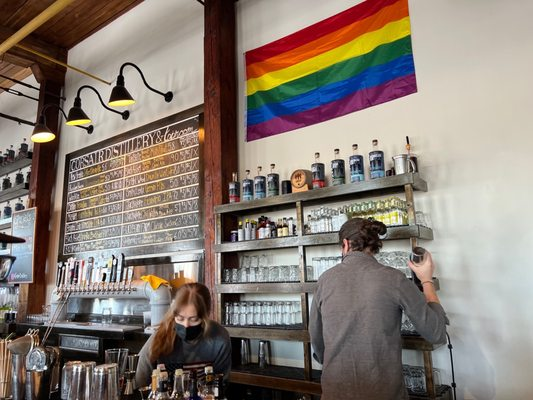

Taille originale => Hauteur: 400, Largeur: 533


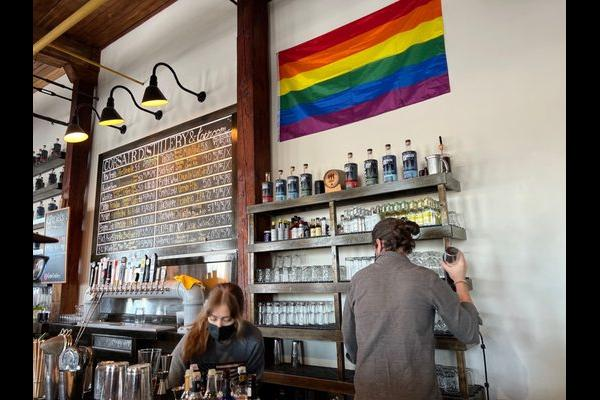

Taille ajustée => Hauteur: 400, Largeur: 600


'data/work/yelp_photos/cnn/1KfbK9IcrbxY1lUkvN1aUA.jpg'

In [77]:
preprocess_image_cnn(photo_id=photo_id_sample, display_evo=True)

### Pré-traitement de l'ensemble de l'échantillon

In [78]:
if PREPROCESS_IMAGES:
    preprocess_images_cnn(df=df_cnn)

### Creation des features depuis cnn VGG16

In [79]:
from keras.applications.vgg16 import VGG16
from keras import Input
input = Input(shape=(height_max, width_max, 3))
model = VGG16(include_top=False,input_tensor=input, weights='imagenet', pooling='max')
model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 600, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 600, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 600, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 300, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 300, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 300, 128)     147584    
                                                              

In [80]:
import keras
def features_cnn(photo_id, model, work_dir = WORK_PHOTOS_DIR):
    img_path = work_dir + 'cnn/' + photo_id + '.jpg'
    img = keras.utils.load_img(img_path)
    x = keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = keras.applications.vgg16.preprocess_input(x)
    features = model.predict(x)
    
    return features[0, :]

In [81]:
if EXTRACT_CNN_FEATURES:
    features = df_cnn['photo_id'].apply(features_cnn, args=(model,))
    df_cnn['features'] = features
    df_cnn.to_parquet('df_cnn')
    df_cnn.sample(3)
else:
    df_cnn = pd.read_parquet('df_cnn')

1/1 [==============================] - 1s 1s/step


In [82]:
df_cnn

photo_id   label  width  height mode  label_num  \
0    4bCgKE0Itp0T8wQXpYsypg  inside  458.0   400.0  RGB          2   
1    RN1AVvw1HXLceaNJkI0GdQ  inside  300.0   400.0  RGB          2   
2    XDVvq4N-wZV5jKVSUYXI2Q  inside  300.0   400.0  RGB          2   
3    IBCtJNh1XJApQSCSzLznlw  inside  533.0   400.0  RGB          2   
4    XIiiz9u9TY5CWjWlUW4pOg  inside  533.0   400.0  RGB          2   
..                      ...     ...    ...     ...  ...        ...   
495  jxxdyVxLYxoAZx_u0Nk15Q    menu  508.0   400.0  RGB          3   
496  gOZd2DVI9UJ7H2P3tl3L0w    menu  259.0   400.0  RGB          3   
497  CmXqOedu60VEv5DNP-uOUQ    menu  266.0   400.0  RGB          3   
498  yS8ClmejCknInl9qOCtyVQ    menu  300.0   400.0  RGB          3   
499  x4acVHke3X7o6hrVaulmQA    menu  533.0   400.0  RGB          3   

                                              features  
0    [35.223938, 33.700726, 25.60686, 12.462739, 3....  
1    [70.471504, 36.02751, 12.21764, 0.0, 39.121506...  
2    [3.3377254, 3.9449198, 0.0, 28.995647, 50.5171...  
3    [47.970963, 31.787832, 21.953196, 19.160604, 3...  
4    [0.0, 62.49378, 28.536165, 76.32434, 79.88776,...  
..                                                 ...  
495  [107.8648, 62.93106, 60.27255, 18.555782, 36.3...  
496  [0.0, 23.820013, 0.0, 0.0, 0.82622284, 0.0, 0....  
497  [3.0549815, 67.442375, 6.7906957, 0.0, 4.54891...  
498  [0.0, 0.0, 60.30077, 0.0, 11.849307, 3.311071,...  
499  [12.708604, 0.0, 0.0, 7.721679, 76.81374, 29.1...  

[500 rows x 7 columns]

### Reduction de dimension

En concervant 99.0% de la variance, la PCA réduit les features de 512 composantes à 339 composantes


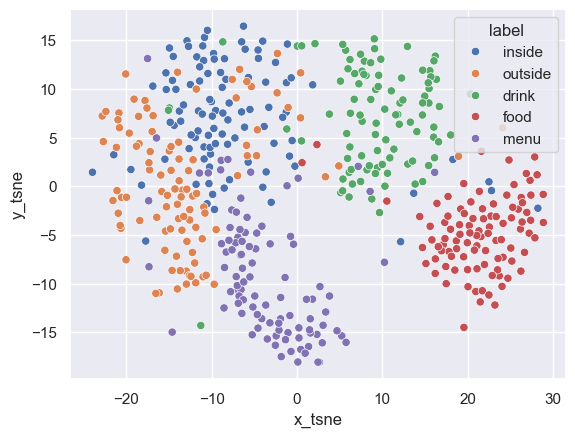

In [83]:
df_cnn = reduc_feature_dim(df_cnn)

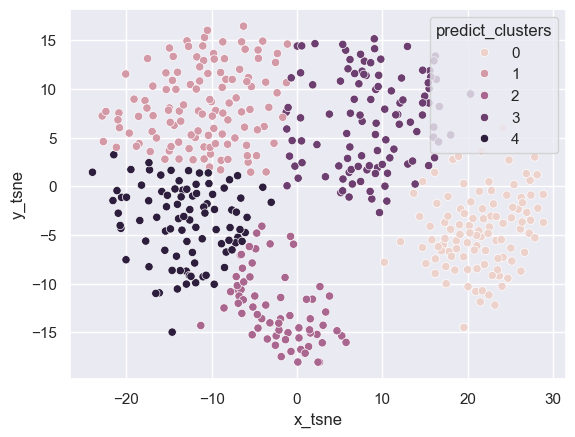

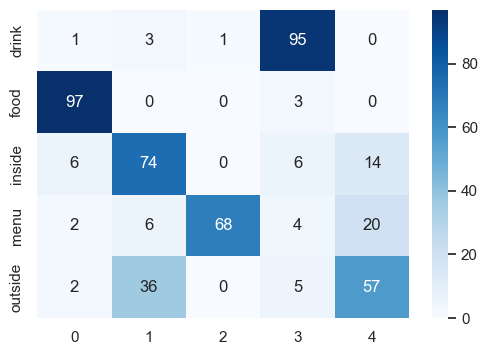

In [91]:
df_cnn = clustering(df_cnn)